In [1]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path

In [2]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]
    
redo_picks = True
if redo_picks:
    earthquakes = earthquakes.iloc[[3,5,6,8,10,17,19,20,21,24,25,26,27,29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

Earthquake 1/14


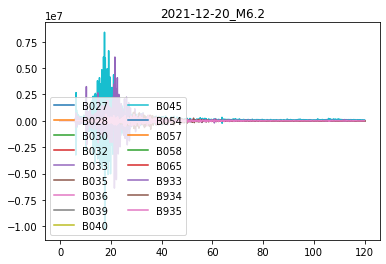

Earthquake 2/14


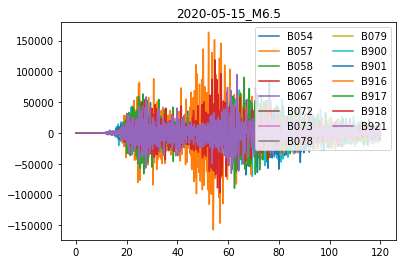

Earthquake 3/14


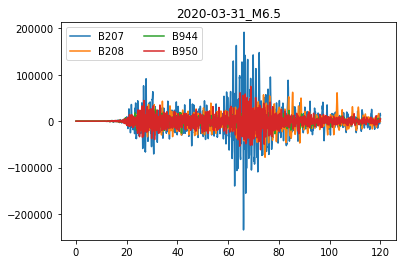

Earthquake 4/14
No data for 2019-12-23_M6
Earthquake 5/14


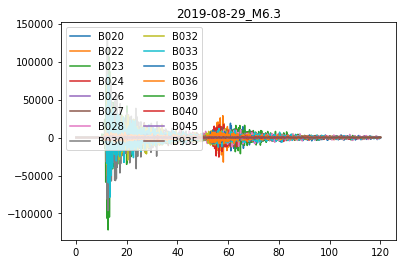

Earthquake 6/14


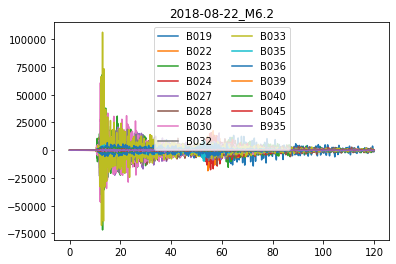

Earthquake 7/14
Skipping 2014-08-24 B076


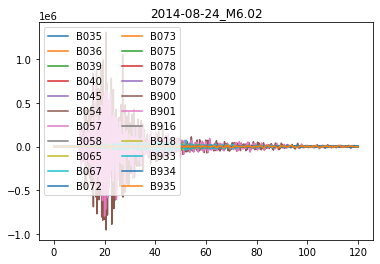

Earthquake 8/14


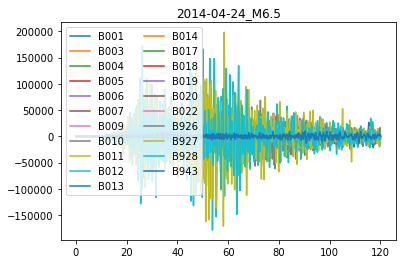

Earthquake 9/14
No data for 2014-03-10T05_M6.8
Earthquake 10/14
No data for 2012-12-14T10_M6.3
Earthquake 11/14


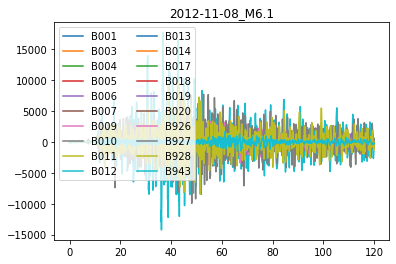

Earthquake 12/14


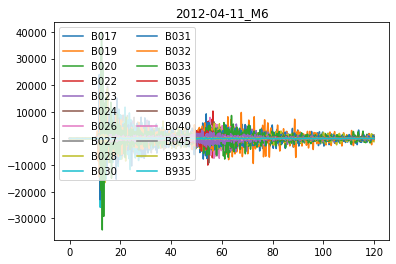

Earthquake 13/14


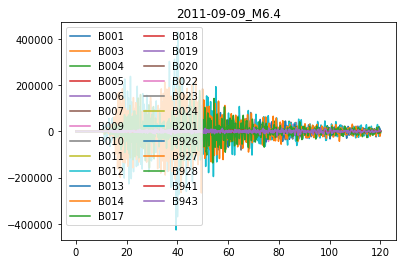

Earthquake 14/14


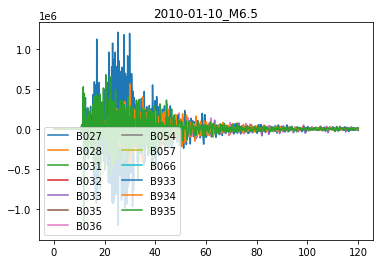

In [3]:
for idx in range(len(earthquakes)):
    
    no_data = False
    ot = origin_times[idx]
    print('Earthquake ' + str(idx+1) + '/' + str(len(mags)))
    
    if idx in rows_for_extra_times:
        cut_ot = ot[:13]
    else:
        cut_ot = ot[:10]
        
    try:
    
        pick_path = path_to_files + 'seismic_data/processed/' + str(cut_ot) + '_M' + str(mags[idx]) + '/picks'
        pick_file = np.genfromtxt(pick_path, dtype = str)
        pick_file_stainfo = pick_file[:,3]

        pick_file_stas = []

        for idx2 in range(len(pick_file_stainfo)):

            pick_file_sta = pick_file_stainfo[idx2].split('.')[1]
            pick_file_stas.append(pick_file_sta)

        pick_file_stas = np.array(pick_file_stas)
    
    except:
        print('No data for ' + str(cut_ot) + '_M' + str(mags[idx]))
        no_data = True
        pass
    
    for sta in stas:
        
        try:
        
            i = np.where(pick_file_stas == sta)[0]
            pick_date = pick_file[i,0][0]
            pick_time = pick_file[i,1][0]
            pick_datetime = UTCDateTime(str(pick_date) + 'T' + str(pick_time) + 'Z')

            starttime = pick_datetime - 10 # 10 seconds before pick time
            endtime = starttime + 120 # full trace will be 2 minutes long

            RMS = read(path_to_files + 'seismic_data/processed/' + str(cut_ot) + '_M' + str(mags[idx]) + '/' + str(sta) + '/EHZ.mseed')
    #         RMS.plot()

            RMS_trim = RMS.trim(starttime = starttime, endtime = endtime, pad = True, fill_value = 0)
    #         RMS_trim.plot()

            # Extracting just the RMS data, now trimmed properly, and saving it to a 
            # new miniSEED file.

            RMS_times_trim = RMS_trim[0].times()
            RMS_data_trim = RMS_trim[0].data
            RMS_trim[0].stats.channel = 'tBSR'
            
            # Plot stations, but avoid plotting the weird stations for the two problem earthquakes
            
            if idx == 4 and sta == 'B072' or sta == 'B076':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))
                
            elif idx == 15 and sta == 'B928':
                print('Skipping ' + str(cut_ot) + ' ' + str(sta))
                
            else:
                plt.title(str(cut_ot) + '_M' + str(mags[idx]))
                plt.plot(RMS_times_trim, RMS_data_trim, label = sta)
#             plt.legend()
#             plt.show()

#             Plot after each station
#             if no_data: 
#                 pass
#             else:
#                 plt.legend(ncol = 2)
#                 plt.show()

            # Create folder for the event
            eq_sta_save_dir = path_to_files + 'seismic_data/trimmed/' + str(cut_ot) + '_M' + str(mags[idx]) + '/'
    #                 print(eq_sta_save_dir)
            if os.path.isdir(eq_sta_save_dir):
                pass
            else:
                os.makedirs(eq_sta_save_dir)

            RMS_trim.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
            
        except:
            pass
    
    # Plot after each earthquake
    if no_data: 
        pass
    else:
        plt.legend(ncol = 2)
        plt.show()  